In [1]:
%matplotlib inline

In [2]:
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

import logging

from ihrem import timeslice
from ihrem.timeslice import Win, ms
from ihrem import paths

from ihrem.figs_comp import fig3

import warnings
from ihrem.analysis import switches as sw

warnings.simplefilter(action='error', category=FutureWarning)
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.INFO)

reg = paths.Registry.read_excel(paths.get_root() / 'registry_merged.xlsx')
exp_events = reg.get_all_events()
print(f'Found {len(reg.experiment_names)} experiments')


bilat_exps = reg.reg.index[(reg.reg[['probe0', 'probe1']] == 'CLA').all(axis=1)]
print(f'Found {len(bilat_exps)} bilat CLA experiments')

Found 57 experiments
Found 44 bilat CLA experiments


# Single Experiment

In [3]:
exp_name = 'GL903_20200716'

valid_win = Win(ms(hours=2), ms(hours=11))

In [4]:
%%time

lead_traces = sw.load_lead_traces(reg, exp_name, exp_valid_win=valid_win)
fig3.patch_last_state(lead_traces)

CPU times: user 17.5 s, sys: 9.13 s, total: 26.6 s
Wall time: 30.5 s


In [5]:
rem_wins = timeslice.Windows.build_from_contiguous_values(lead_traces['rem_state'])
lead_wins = timeslice.Windows.build_from_contiguous_values(lead_traces['lead_state'])
    
cycles_raw = sw.Cycles(
        sw.classify_wins_by_cycle(lead_wins, sw.extract_cycle_wins(rem_wins))
)

cycles_filtered = fig3.filter_bad_rem(cycles_raw)

  0%|          | 0/214 [00:00<?, ?it/s]

Dropping 1/214 (0.5%) suspiciously long REM periods


In [6]:
beta = reg.load_all_beta_norm(exp_name, exp_valid_win=valid_win)

In [7]:
%%time

full_xcorr = sw.load_xcorr(reg, exp_name, tau=1000, suffix='_exp', low_hz=40)
full_xcorr = full_xcorr.sel_between(lag=(-50, +50))

CPU times: user 3.6 s, sys: 8.84 s, total: 12.4 s
Wall time: 18.5 s


## Example dominance period classification (Fig. 3 a & b)

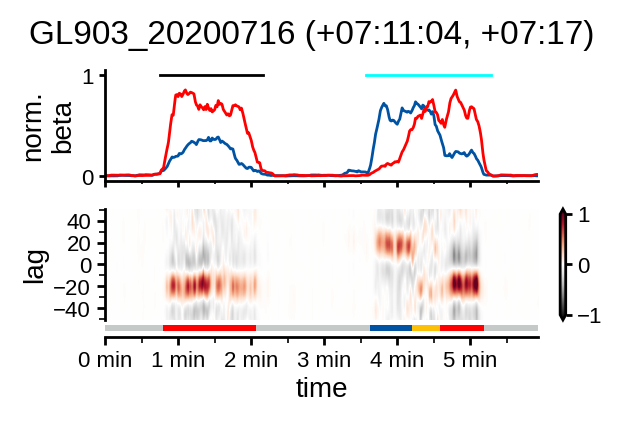

In [8]:
zoom_win = Win(25864000.0, 26220000.0)
highlight_wins = {
    'xkcd:black': Win(25914001.0, 25989001.0).extend(-5000, +5000),
    'xkcd:cyan': Win(26083001.0, 26176001.0).extend(-5000, +5000),
}


axs = fig3.plot_example_switch(full_xcorr, beta, lead_wins, zoom_win, highlight_wins, suptitle=f'{exp_name} {zoom_win}')
axs.ravel()[0].figure.savefig(f'figs/{exp_name}_example_switch.pdf')

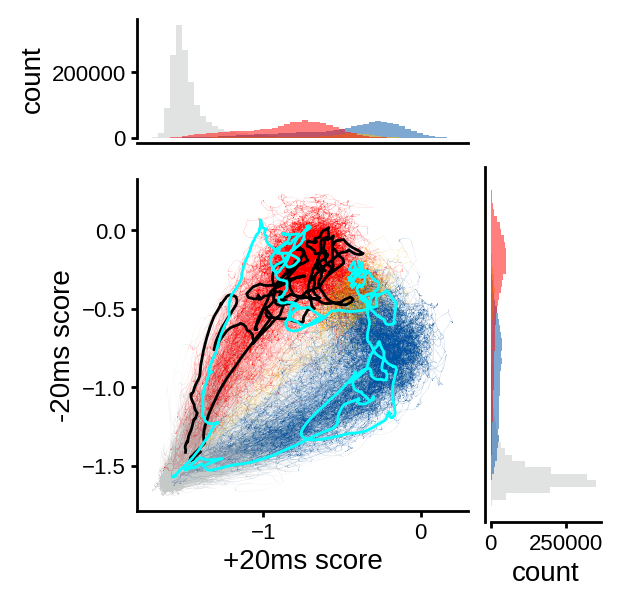

In [9]:
axs = fig3.plot_state_space_with_traces(lead_traces, highlight_wins, rasterized=True)
list(axs.values())[0].figure.savefig(f'figs/{exp_name}_example_switch_statespace.pdf', dpi=600)

## All dominance periods (Fig. 3 c)

  0%|          | 0/213 [00:00<?, ?it/s]

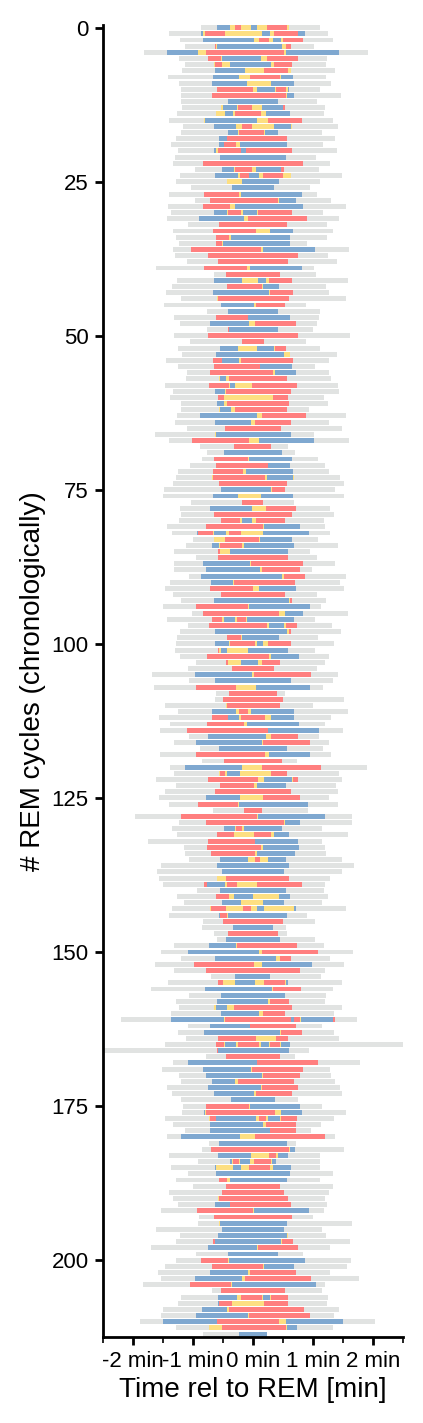

In [10]:
ax = fig3.plot_lead_state_cycles(cycles_filtered.align_to_rem_center())
ax.figure.savefig(f'{exp_name}_barcodes.pdf')

## One-switch dominance durations (Fig. 3 e)

In [11]:
cycles = cycles_filtered

dom_counts = cycles.get_period_counts_per_cycle()
switch_counts = cycles.get_switch_count_per_cycle()
rem_lengths = cycles.get_rem_wins().lengths()

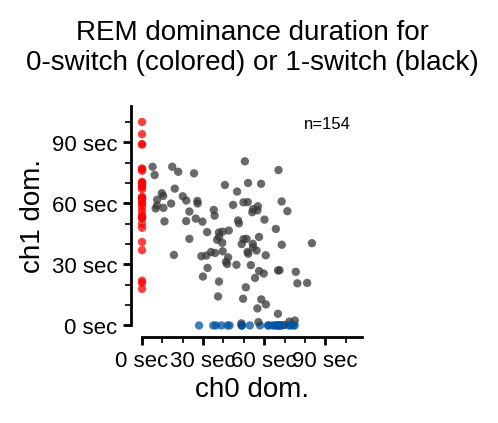

In [12]:
lengths = cycles.get_period_lengths_per_cycle()
lengths_norm = (lengths.T / rem_lengths).T.dropna()


interesting = dom_counts['lead_ch0'].isin([0, 1]) & dom_counts['lead_ch1'].isin([0, 1])
ax = fig3.plot_one_switch_dom_durations_simple(lengths.loc[interesting], switch_counts.loc[interesting])
ax.figure.savefig(f'figs/{exp_name}_duration_sw.pdf')

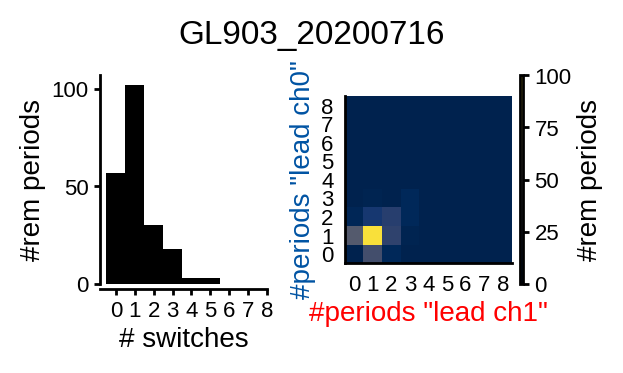

In [13]:
period_counts = cycles_filtered.get_period_counts_per_cycle()

axs = sw.plot_lead_state_cycle_counts(period_counts, suptitle=exp_name)
axs[0].figure.savefig(f'{exp_name}_switchcounts.pdf')

# Late night dynamics (Fig. 3 d)

In [14]:
%%time

exp_lead_traces_late = fig3.load_multiple_lead_traces_extended(
    reg,
    [
        'GL903_20200716',
        'GL1003_20201031',
    ],
)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 20.8 s, sys: 16.1 s, total: 36.8 s
Wall time: 48.6 s


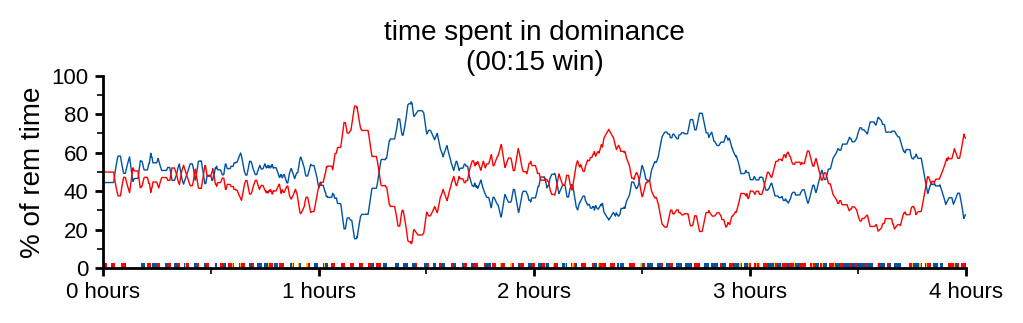

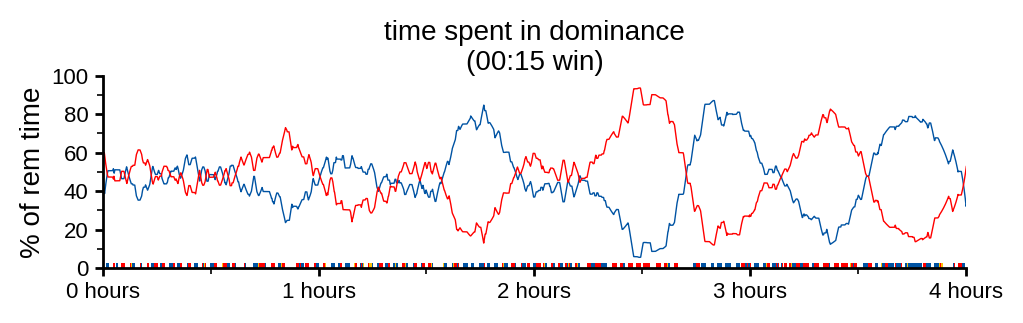

In [15]:
for name, lead_traces_late in exp_lead_traces_late.items():
    fig3.study_late_time_spent(reg, name, lead_traces_late)

## Slow REM dynamics (EDF4 a & b)

In [16]:
exp_names = [
    'GL1018_20210813',
    'GL1003_20201031',
    'GL903_20200716',
    'GL598_20191205',
]

In [17]:
exp_cycles_filtered = fig3.load_multiple_exp_cycles(reg, exp_names)

load:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

Dropping 11/223 (4.9%) suspiciously long REM periods
Dropping 6/228 (2.6%) suspiciously long REM periods
Dropping 1/214 (0.5%) suspiciously long REM periods
Dropping 19/191 (9.9%) suspiciously long REM periods


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

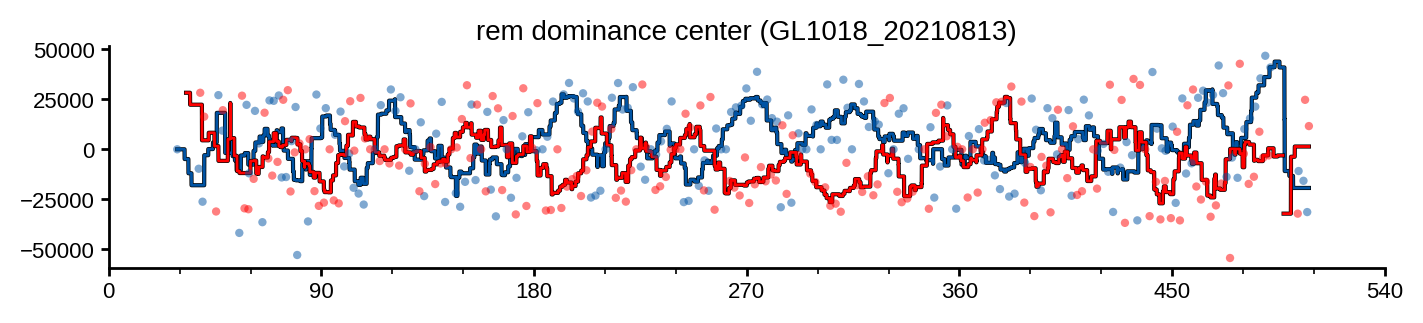

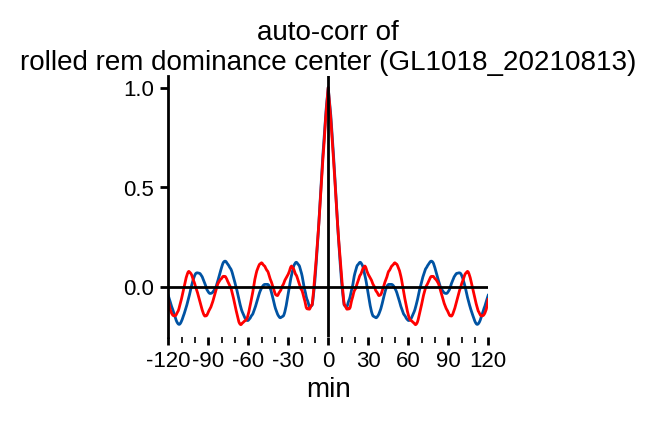

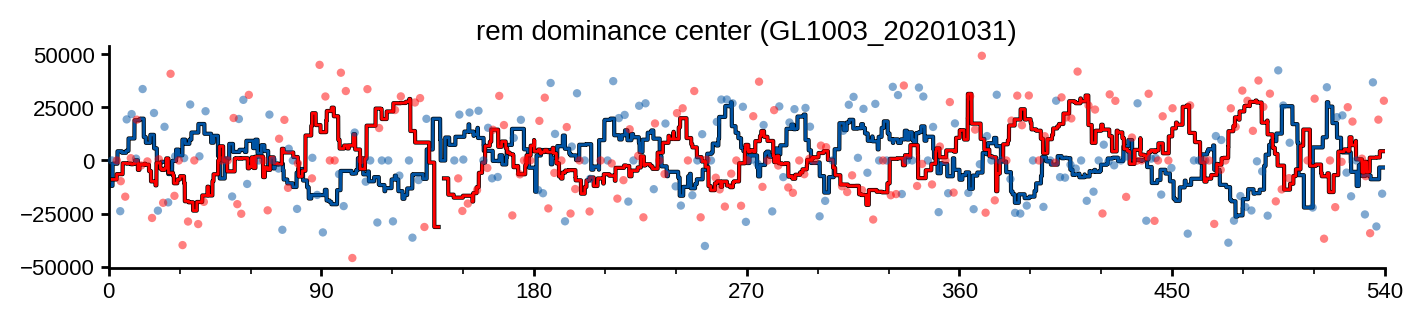

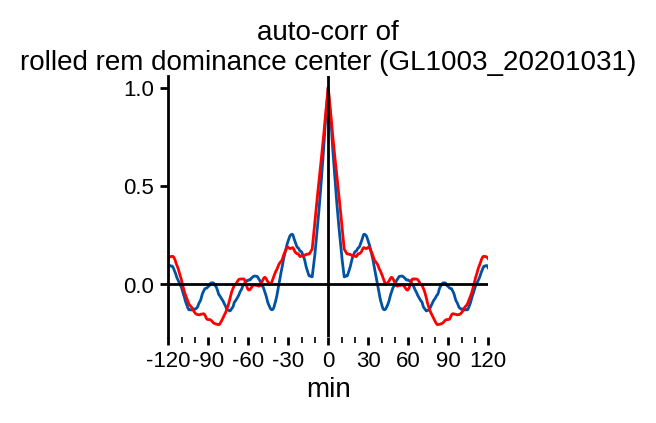

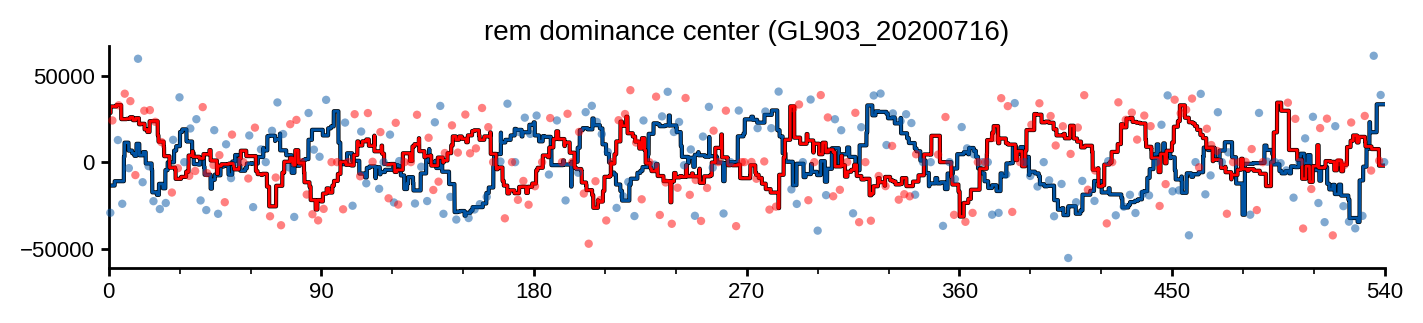

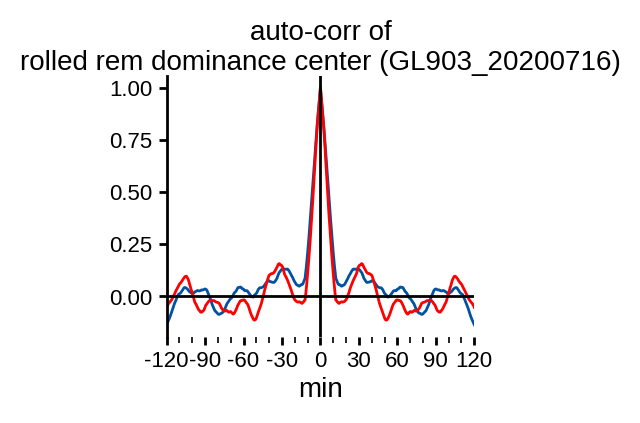

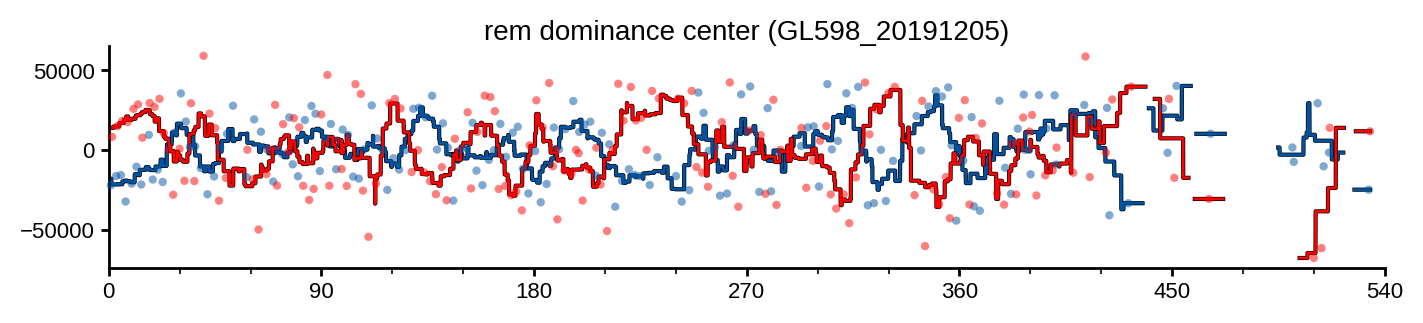

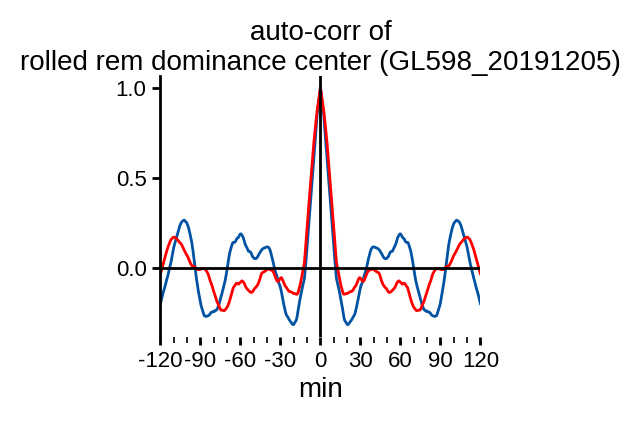

In [18]:
fig3.study_all_center_of_main(
    desc='rem_dominance_center',
    exp_samples={
        exp_name: fig3.get_samples_center_largest(cycles.shift(ms(hours=-2)))
        for exp_name, cycles in exp_cycles_filtered.items()
    })